## Step 0 - a working BEELINE directory

```
os.chdir('../..')
git clone https://github.com/murali-group/BEELINE
#### if needed, . setupAnacondaVENV.sh

cd BEELINE
grep -rl --include="*.py" "docker" BLRun | xargs sed -i 's/docker/podman/g'
cd ..

from src.py.beeline_config_utils import init_config, save_config, load_config, add_datasets, toggle_algorithm, set_algorithms, ALL_ALGOS

# --- Create initial config ---
datasets = ["kim23-hm1_STRING12_K-3-MEANS1000TFs"]
algos_to_run = ["GENIE3", "GRNBOOST2"]

config = init_config(datasets, algos_to_run)
save_config(config, "beeline_config.yaml")

# --- Later: modify config ---
config = load_config("beeline_config.yaml")
add_datasets(config, ["kim23-hm1_STRING12_K-5-MEANS1000TFs"])
toggle_algorithm(config, "GENIE3", run=False)
toggle_algorithm(config, "GRNBOOST2", run=True)
save_config(config, "beeline_config_modified.yaml")
```

Here we preprocess scRNA and prepare input data for the BEELINE-like workflow.

## Step 1 - scRNA-seq data preparation

In [1]:
import scanpy as sc
import pandas as pd
import sys
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad
from pathlib import Path


In [2]:
# --- Configuration ---
os.chdir('../..')
tf_file = 'data/human-tfs.csv'
network_file = 'data/9606_protein_links_gene_names_combined_score_700.csv'
network_name = 'STRING12'
beeline_dir = 'BEELINE/'
beeline_dir = Path(beeline_dir)

### Buenrostro 2018 data

In [3]:
dataset_name = 'buenrostro18'
# Number of highly variable genes to select
n_top_hvg = 1000
# Whether to include HV TFs in the analysis
include_hv_tfs = True
tfs_suffix = 'TFs' if include_hv_tfs else ''
# Directory to save the processed data
output_dir = beeline_dir / 'inputs' / dataset_name
os.makedirs(output_dir, exist_ok=True)

In [4]:
param_prefix = output_dir / f"{dataset_name}_{network_name}_{n_top_hvg}{tfs_suffix}"


In [5]:
## --- 1. Load Data ---

# Read the expression matrix
expr_df = pd.read_csv("data/Buenrostro2018/buenrostro_2018_scRNAseq.txt", sep = '\t', index_col=0).T

# Create AnnData object
adata = ad.AnnData(X=expr_df)

# Optional: move gene names to .var
adata.var_names = expr_df.columns
adata.obs_names = expr_df.index


In [6]:
adata.obs_names

Index(['hsc_1', 'hsc_2', 'hsc_3', 'hsc_4', 'hsc_5', 'hsc_6', 'hsc_7', 'hsc_8',
       'hsc_9', 'hsc_10',
       ...
       'cd34_14423', 'cd34_14424', 'cd34_14425', 'cd34_14426', 'cd34_14427',
       'cd34_14428', 'cd34_14429', 'cd34_14430', 'cd34_14431', 'cd34_14432'],
      dtype='object', length=14432)

In [7]:
print(f"Initial AnnData shape: {adata.shape}") # (cells, genes)

print(f"Reading TF list: {tf_file}")
tfs_df = pd.read_csv(tf_file, header=0)
all_known_tfs = set(tfs_df[tfs_df.columns[0]])

print(f"Reading network: {network_file}")
net_df = pd.read_csv(network_file)
print(f"Initial network shape: {net_df.shape}")


Initial AnnData shape: (14432, 12558)
Reading TF list: /home/kl467102/Beeline-238/inputs/hHep/human-tfs.csv
Reading network: /home/kl467102/string_dir/9606_protein_links_gene_names_combined_score_700.csv
Initial network shape: (472000, 2)


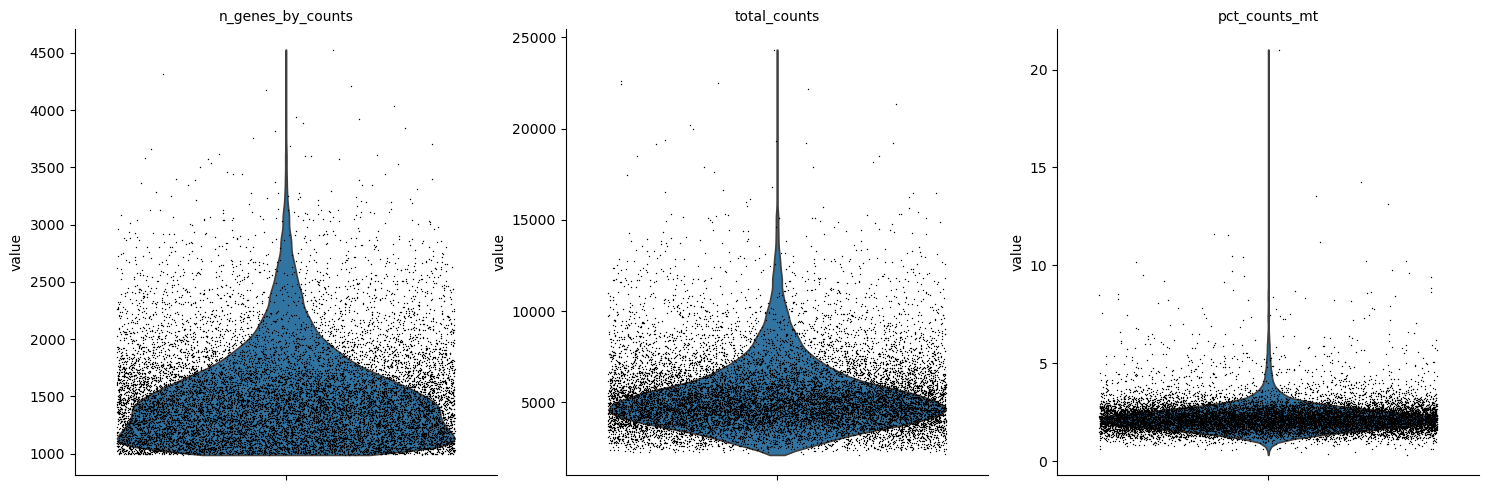

In [8]:
## --- 2. Preprocess Data ---
adata_rna = adata.copy()
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata_rna.var["mt"] = adata_rna.var_names.str.startswith("MT-")
# ribosomal genes
adata_rna.var["ribo"] = adata_rna.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata_rna.var["hb"] = adata_rna.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata_rna, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

fig = sc.pl.violin(
    adata_rna,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True
)


Here, the data looks already preprocessed


In [9]:
# We can further filter out some cells
sc.pp.filter_cells(adata_rna, max_genes=2500)
adata_rna = adata_rna[adata_rna.obs.pct_counts_mt < 5, :]

adata_rna.shape


(13779, 12558)

In [10]:
adata_rna.obs['sample_type'] = adata_rna.obs_names.str.split('_').str[0]

/tmp/ipykernel_1893/2864902475.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_rna.obs['sample_type'] = adata_rna.obs_names.str.split('_').str[0]


In [11]:
# normalize and logarithmize
adata_rna.raw = adata_rna.copy()
adata_rna.layers['counts']=adata_rna.X.copy() 
sc.pp.normalize_total(adata_rna, target_sum=1e4)
sc.pp.log1p(adata_rna)
sc.pp.highly_variable_genes(adata_rna, n_top_genes=None)


In [12]:
adata_rna

AnnData object with n_obs × n_vars = 13779 × 12558
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'sample_type'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [13]:
sc.tl.pca(adata_rna)
sc.pp.neighbors(adata_rna)
sc.tl.umap(adata_rna)
sc.tl.leiden(adata_rna, flavor="igraph")


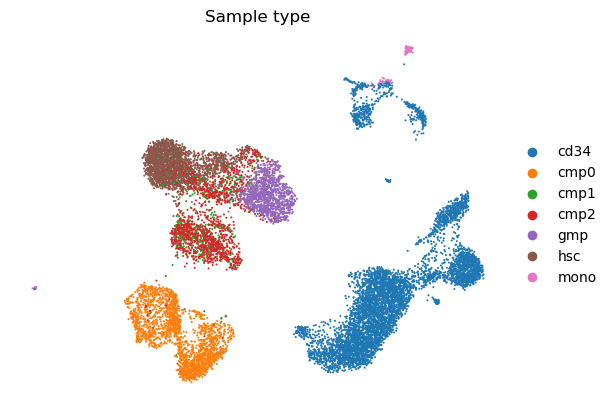

In [14]:
sc.pl.umap(adata_rna, color="sample_type", frameon=False,  title='Sample type')

In [15]:
adata_path = output_dir / f"{dataset_name}.h5ad"
adata_rna.write(adata_path)
print(f"Saved processed AnnData to {adata_path}")
adata_rna = sc.read(adata_path)

Saved processed AnnData to /home/kl467102/thesis/BEELINE/inputs/buenrostro18/buenrostro18.h5ad


### Preparing input for Beeline

In [16]:
genes_in_data = set(adata_rna.var_names)
tfs_in_data = all_known_tfs.intersection(genes_in_data)
print(f"Found {len(tfs_in_data)} TFs present in the expression data.")

Found 1121 TFs present in the expression data.


In [17]:
sc.pp.highly_variable_genes(adata_rna, n_top_genes=None)
default_mask = adata_rna.var['highly_variable'].copy()
n_default = default_mask.sum()
print(f"Default HVGs: {n_default}")
# Cutoff HVGs
sc.pp.highly_variable_genes(adata_rna, n_top_genes=n_top_hvg)
cutoff_mask = adata_rna.var['highly_variable'].copy()
n_cutoff = cutoff_mask.sum()
print(f"Top {n_top_hvg} HVGs: {n_cutoff}")
# Include TFs
tf_mask = adata_rna.var_names.isin(all_known_tfs)
tf_in_default = default_mask & tf_mask
n_tf_default = tf_in_default.sum()
print(f"TFs in default HVGs: {n_tf_default}")
combined = cutoff_mask.copy()
if include_hv_tfs:
    combined |= tf_in_default
    added = combined.sum() - n_cutoff
    print(f"Including additional {added} TFs → total combined HVGs: {combined.sum()}")



Default HVGs: 1182
Top 1000 HVGs: 1000
TFs in default HVGs: 123
Including additional 19 TFs → total combined HVGs: 1019


In [18]:
os.makedirs(param_prefix, exist_ok=True)

In [19]:
ad_hvg = adata_rna[:, combined].copy()
ad_hvg_path = output_dir / f"{dataset_name}_{network_name}_{n_top_hvg}{tfs_suffix}.h5ad"
ad_hvg.write(ad_hvg_path)
ad_hvg = sc.read(ad_hvg_path)
expr_df = pd.DataFrame(
    ad_hvg.X,
    index=ad_hvg.obs_names,
    columns=ad_hvg.var_names
).T
print(f"HVG subset shape: cells={ad_hvg.n_obs}, genes={ad_hvg.n_vars}\n")
    
    
filtered_net_df = net_df[
    net_df['Gene1'].isin(ad_hvg.var.index) &
    net_df['Gene2'].isin(ad_hvg.var.index)
].copy()
filtered_net_df = filtered_net_df[filtered_net_df['Gene1'] != filtered_net_df['Gene2']]
filtered_net_df.drop_duplicates(keep='first', inplace=True)
expr_file = param_prefix / 'ExpressionData.csv'
expr_df.to_csv(expr_file, index=True)
filtered_network_filename = param_prefix / 'refNetwork.csv'
filtered_net_df.to_csv(filtered_network_filename, index=False)

print(f"Saved filtered expression data to {expr_file}")
print(f"Saved filtered network to {filtered_network_filename}")


HVG subset shape: cells=13779, genes=1019

Saved filtered expression data to /home/kl467102/thesis/BEELINE/inputs/buenrostro18/buenrostro18_STRING12_1000TFs/ExpressionData.csv
Saved filtered network to /home/kl467102/thesis/BEELINE/inputs/buenrostro18/buenrostro18_STRING12_1000TFs/refNetwork.csv


Creating config file for BEELINE.

In [20]:
from src.py.beeline_config_utils import init_config, save_config, load_config, add_datasets, toggle_algorithm, set_algorithms, ALL_ALGOS

datasets = []
datasets.append(param_prefix.name)
algos_to_run = ["GENIE3", "GRNBOOST2", "PIDC"]

config = init_config(datasets, algos_to_run, dataset_dir=dataset_name, output_prefix=dataset_name)


In [21]:
config_path = beeline_dir / 'config-files' / f"{dataset_name}_config.yaml"
save_config(config, config_path)

Config saved to /home/kl467102/thesis/BEELINE/config-files/buenrostro18_config.yaml
